# A/B Test Analysis & Experimentation Insights
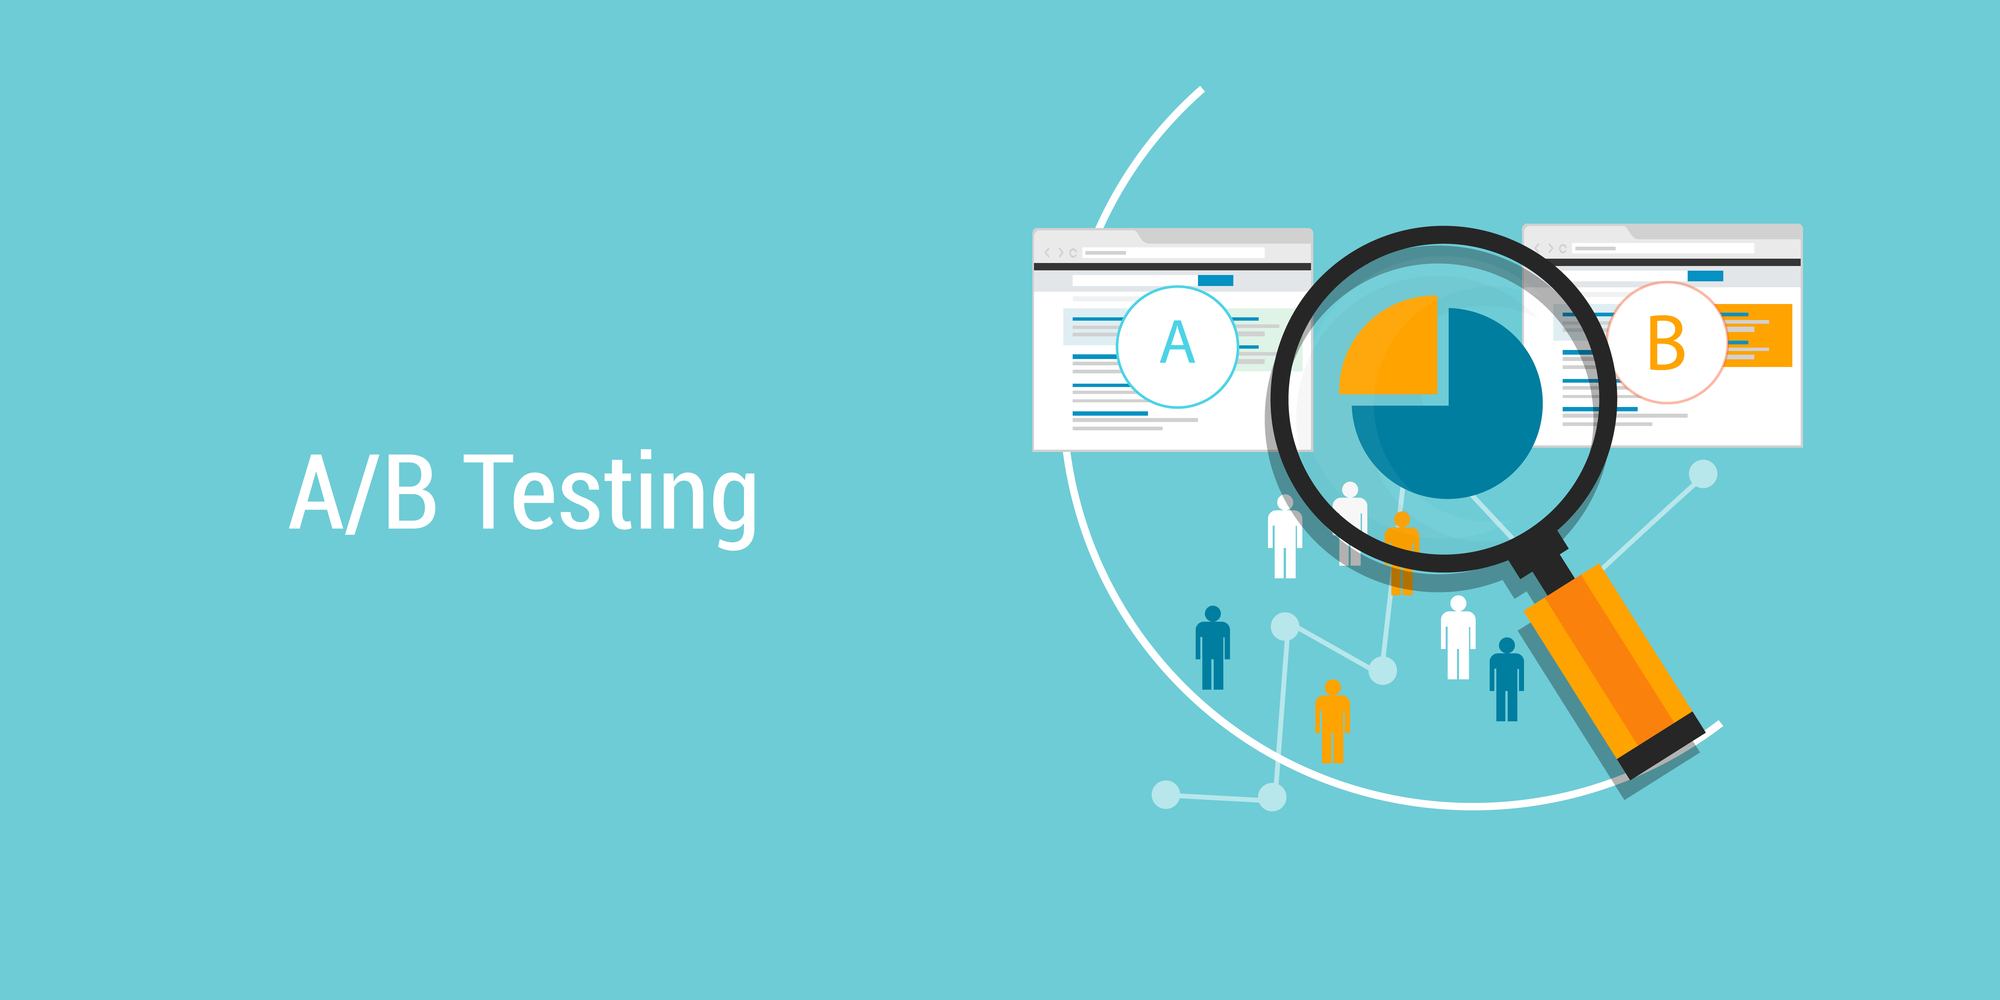

#   Import Libraries

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu,pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings("ignore")

# Read Dataset

In [5]:
df = pd.read_csv(r"marketing_AB.csv")

In [59]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour,converted2,weekdays_weekends
0,2,1144181,ad,False,21,Tuesday,18,0,weekdays
1,7,1496843,ad,False,17,Sunday,18,0,weekends
2,8,1448851,ad,False,21,Tuesday,19,0,weekdays
3,11,1637531,ad,False,47,Wednesday,13,0,weekdays
4,12,1081965,ad,False,61,Tuesday,20,0,weekdays


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         5 non-null      int64 
 1   user id            5 non-null      int64 
 2   test group         5 non-null      object
 3   converted          5 non-null      bool  
 4   total ads          5 non-null      int64 
 5   most ads day       5 non-null      object
 6   most ads hour      5 non-null      int64 
 7   converted2         5 non-null      int64 
 8   weekdays_weekends  5 non-null      object
dtypes: bool(1), int64(5), object(3)
memory usage: 457.0+ bytes


In [6]:
df.loc[(df.converted == True),  'converted2'] = 1
df.loc[(df.converted == False),  'converted2'] = 0
df["converted2"] = df["converted2"].astype(int)

## Removing Outliers

In [7]:
def drop_outlier(df, col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[[col]])
    plt.title(f'{col} Boxplot')
    plt.show()
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    down_limit = Q1 - 1.5 * IQR
    up_limit = Q3 + 1.5 * IQR
    
    df = df[~((df[col] < down_limit) | (df[col] > up_limit))]
    return df

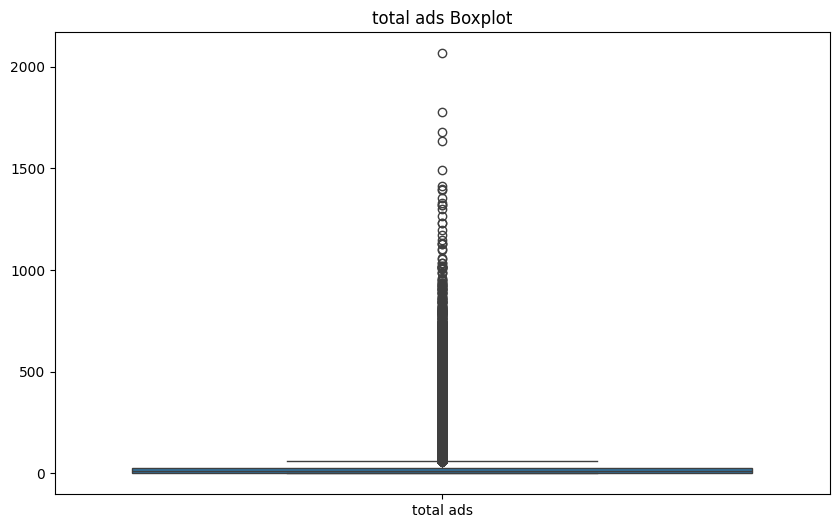

In [8]:
df = drop_outlier(df, 'total ads')

## Total Ads Viewed vs Purchase Status by Test Group

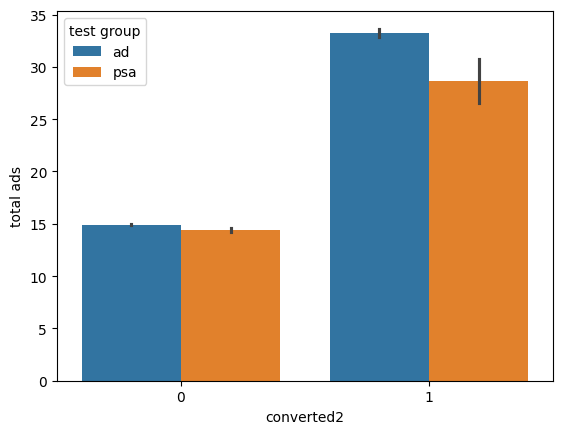

In [9]:
sns.barplot(df, x = 'converted2', y = 'total ads', hue = 'test group');

In [10]:
df_groupby = df.groupby(["test group","most ads day"]).agg({"total ads":"mean", "converted2":"sum"}).reset_index()
df_groupby.head()

,test group,most ads day,total ads,converted2
0,ad,Friday,15.255024,958
1,ad,Monday,14.825415,1324
2,ad,Saturday,15.944834,777
3,ad,Sunday,15.679764,987
4,ad,Thursday,14.510822,835


## Relationship between Purchase Status, Total Ads Viewed, and Most Ads Day by Test Group

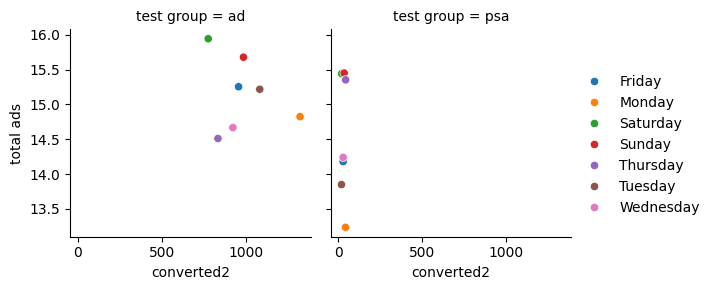

In [11]:
g = sns.FacetGrid(df_groupby, col="test group")
g.map(sns.scatterplot, 'converted2', 'total ads', 'most ads day')
g.add_legend()
plt.show()

## Kernel Density Estimation of Total Ads Viewed by Most Ads Day

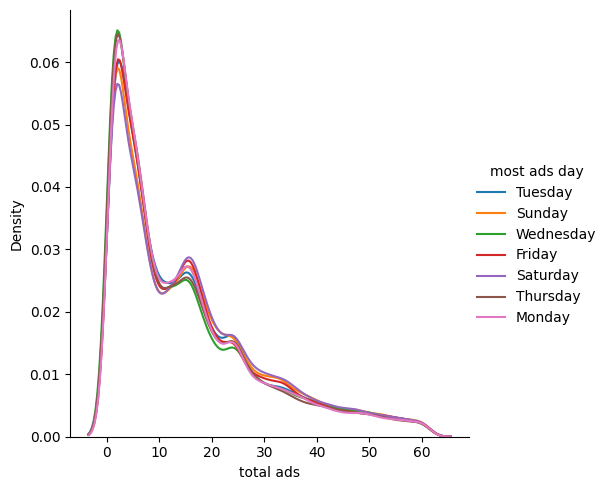

In [12]:
(sns
 .FacetGrid(df,
              hue = "most ads day",
              height = 5
           )
 .map(sns.kdeplot, "total ads", shade= False)
 .add_legend()
);

## Kernel Density Estimation of Total Ads Viewed by Test Group

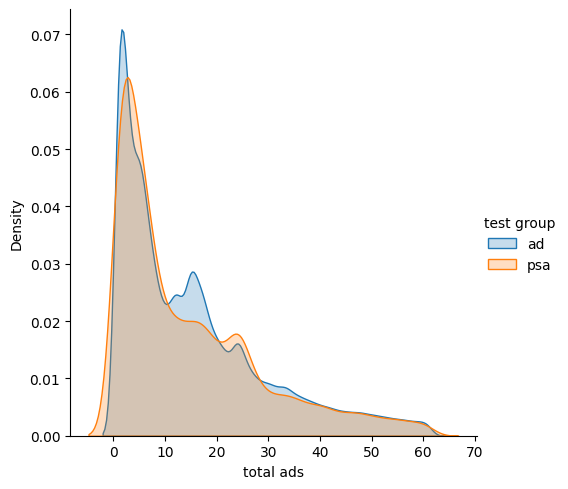

In [13]:
(sns
 .FacetGrid(df,
              hue = "test group",
              height = 5
           )
 .map(sns.kdeplot, "total ads", shade= True)
 .add_legend()
);

## Total Ads Viewed by Most Ads Day and Test Group

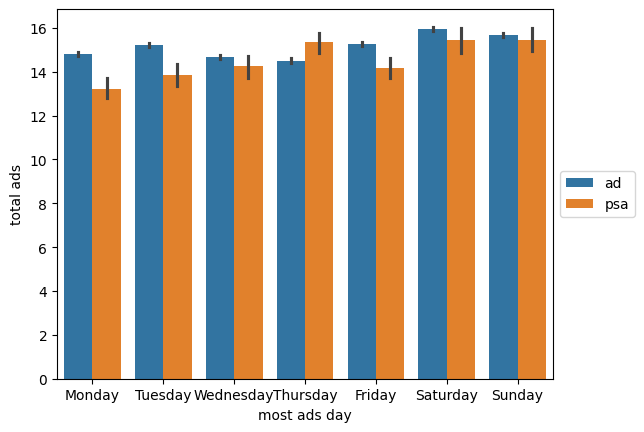

In [14]:
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

sns.barplot(data=df, x='most ads day', y='total ads', hue='test group', order=days_order)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


## Total Ads Viewed by Most Ads Hour and Test Group

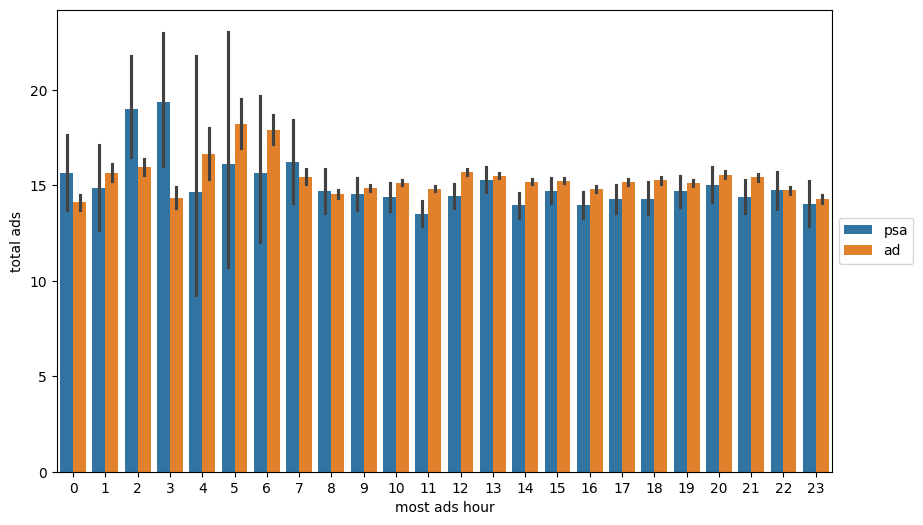

### compare_groups_test Function
#### * This function compares two groups based on a specified target variable, considering assumptions of normality and homogeneity of variances.
#### * If these assumptions are met, it applies a t-test; otherwise, it uses the Mann-Whitney U Test for non-parametric comparison.

In [23]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour,converted2,weekdays_weekends
2,2,1144181,ad,False,21,Tuesday,18,0,weekdays
7,7,1496843,ad,False,17,Sunday,18,0,weekends
8,8,1448851,ad,False,21,Tuesday,19,0,weekdays
11,11,1637531,ad,False,47,Wednesday,13,0,weekdays
12,12,1081965,ad,False,61,Tuesday,20,0,weekdays


In [62]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour,converted2,weekdays_weekends
0,2,1144181,ad,False,21,Tuesday,18,0,weekdays
1,7,1496843,ad,False,17,Sunday,18,0,weekends
2,8,1448851,ad,False,21,Tuesday,19,0,weekdays
3,11,1637531,ad,False,47,Wednesday,13,0,weekdays
4,12,1081965,ad,False,61,Tuesday,20,0,weekdays


In [63]:
# Define columns
group_col = 'test group'
target_col = 'converted2'

# Testing

In [43]:
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

def compare_groups_test(df, group_col, test_value, control_value, target_col):
    """
    Compare two groups on a target column using statistical tests.
    
    Steps:
    1. Check normality (Shapiro test)
    2. Check homogeneity of variances (Levene test)
    3. Apply T-test if assumptions met, else Mann-Whitney U test
    """
    
    print("-"*100)
    print("Step 1: Normality Check (Shapiro Test)")
    
    test_group = df.loc[df[group_col] == test_value, target_col]
    control_group = df.loc[df[group_col] == control_value, target_col]
    
    t_stat_test, p_test = shapiro(test_group)
    t_stat_control, p_control = shapiro(control_group)
    
    normal_test = p_test > 0.05 and p_control > 0.05
    if normal_test:
        print(f"  * Normality satisfied. Test p-values: {p_test:.4f}, {p_control:.4f}")
    else:
        print(f"  * Normality NOT satisfied. Test p-values: {p_test:.4f}, {p_control:.4f}")
    
    print("-"*100)
    print("Step 2: Homogeneity of Variances (Levene Test)")
    
    lev_stat, lev_p = levene(test_group, control_group)
    equal_var = lev_p > 0.05
    if equal_var:
        print(f"  * Variances are homogeneous. p-value = {lev_p:.4f}")
    else:
        print(f"  * Variances are NOT homogeneous. p-value = {lev_p:.4f}")
    
    print("-"*100)
    print("Step 3: Group Comparison Test")
    
    if normal_test:  # Parametric
        t_stat, p_val = ttest_ind(test_group, control_group, equal_var=equal_var)
        test_name = "T-Test"
    else:  # Non-parametric
        t_stat, p_val = mannwhitneyu(test_group, control_group)
        test_name = "Mann-Whitney U Test"
    
    result = "Reject H0" if p_val < 0.05 else "Cannot Reject H0"
    print(f"{test_name}: Stat = {t_stat:.4f}, p-value = {p_val:.4f} --> {result}")


#### * H0 (Null Hypothesis): There is no statistically significant difference in the mean total number of advertisements between the groups of purchase status 0 (not purchased) and 1 (purchased).
#### * H1 (Alternative Hypothesis): There is a statistically significant difference in the mean total number of advertisements between the groups of purchase status 0 and 1.

In [50]:
# Suppose you want to compare "total ads" for converted 0 vs 1
test_group = df.loc[df["converted"] == 1, "total ads"]
control_group = df.loc[df["converted"] == 0, "total ads"]

# Only run Shapiro if both groups have >= 3 values
if len(test_group) < 3 or len(control_group) < 3:
    print("Not enough data for Shapiro test. Skipping normality check.")
    normal_test = False
else:
    t_stat_test, p_test = shapiro(test_group)
    t_stat_control, p_control = shapiro(control_group)
    normal_test = (p_test > 0.05) and (p_control > 0.05)
    print(f"Shapiro Test - Test p={p_test:.4f}, Control p={p_control:.4f}")


Not enough data for Shapiro test. Skipping normality check.


In [51]:
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

def compare_groups_test(df, group_col, test_value, control_value, target_col):
    """
    Compare two groups on a target column using statistical tests.
    
    Steps:
    1. Normality Check (Shapiro)
    2. Homogeneity of Variance (Levene)
    3. T-test or Mann-Whitney U test
    """

    print("-"*100)
    print("Step 1: Normality Check (Shapiro Test)")

    test_group = df.loc[df[group_col] == test_value, target_col]
    control_group = df.loc[df[group_col] == control_value, target_col]

    # Safe normality check
    if len(test_group) < 3 or len(control_group) < 3:
        print("Not enough data for Shapiro test. Skipping normality check.")
        normal_test = False
    else:
        t_stat_test, p_test = shapiro(test_group)
        t_stat_control, p_control = shapiro(control_group)
        normal_test = (p_test > 0.05) and (p_control > 0.05)
        print(f"Shapiro Test - Test p={p_test:.4f}, Control p={p_control:.4f}")
        print("  * Normality satisfied" if normal_test else "  * Normality NOT satisfied")

    print("-"*100)
    print("Step 2: Homogeneity of Variances (Levene Test)")

    lev_stat, lev_p = levene(test_group, control_group)
    equal_var = lev_p > 0.05
    print(f"Levene Test p={lev_p:.4f} --> {'Homogeneous' if equal_var else 'Not Homogeneous'}")

    print("-"*100)
    print("Step 3: Group Comparison Test")

    # Choose test
    if normal_test:
        t_stat, p_val = ttest_ind(test_group, control_group, equal_var=equal_var)
        test_name = "T-Test"
    else:
        t_stat, p_val = mannwhitneyu(test_group, control_group)
        test_name = "Mann-Whitney U Test"

    result = "Reject H0" if p_val < 0.05 else "Cannot Reject H0"
    print(f"{test_name}: Stat = {t_stat:.4f}, p-value = {p_val:.4f} --> {result}")

    return {
        "test_name": test_name,
        "statistic": t_stat,
        "p_value": p_val,
        "normality": normal_test,
        "equal_variance": equal_var,
        "result": result
    }


#### * H0 (Null Hypothesis): There is no statistically significant difference in the mean total number of advertisements between individuals who see the most advertisements on weekdays and weekends.
#### * H1 (Alternative Hypothesis): There is a statistically significant difference in the mean total number of advertisements between individuals who see the most advertisements on weekdays and weekends.

In [18]:
def add_weekday_weekend_column(df, day_column, new_column_name):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekends = ['Saturday', 'Sunday']
    
    # Yeni sütunu oluşturma ve her güne göre etiketleme
    df[new_column_name] = df[day_column].apply(lambda x: 'weekdays' if x in weekdays else 'weekends' if x in weekends else 'Other')
    
    return df


df = add_weekday_weekend_column(df, 'most ads day', 'weekdays_weekends')

In [19]:
compare_groups_test(df,"weekdays_weekends", "weekdays", "weekends", "total ads")

------------------------------------------------------------------------------------------------------------------------------------------------------
Assumption Check Step 1
  - Normality Assumption (Shapiro Test)

       * Normality assumption is not satisfied.

       * Test Group Stat = 0.8592, p-value = 0.0000

       * Test Stat Control = 0.8783, p-value = 0.0000
------------------------------------------------------------------------------------------------------------------------------------------------------
Assumption Check Step 2
  - Homogeneity of Variances (Levene Test)

       * Variances are not homogeneous.

       * Test Stat = 199.2477, p-value = 0.0000
------------------------------------------------------------------------------------------------------------------------------------------------------
If Assumptions are Not Met, Apply Mann-Whitney U Test (Non-Parametric Test)

  * Reject H0

  * T Test Stat = 28083790182.0000, p-value = 0.0000


#### * H0 (Null Hypothesis): There is no statistically significant difference in the mean total ad count between the advertisement group ("ad") and the public service announcement group ("psa").
#### * H1 (Alternative Hypothesis): There is a statistically significant difference in the mean total ad count between the advertisement group ("ad") and the public service announcement group ("psa").

In [20]:
compare_groups_test(df,"test group", "ad", "psa", "total ads")

------------------------------------------------------------------------------------------------------------------------------------------------------
Assumption Check Step 1
  - Normality Assumption (Shapiro Test)

       * Normality assumption is not satisfied.

       * Test Group Stat = 0.8651, p-value = 0.0000

       * Test Stat Control = 0.8476, p-value = 0.0000
------------------------------------------------------------------------------------------------------------------------------------------------------
Assumption Check Step 2
  - Homogeneity of Variances (Levene Test)

       * Variances are homogeneous.

       * Test Stat = 0.1915, p-value = 0.6617
------------------------------------------------------------------------------------------------------------------------------------------------------
If Assumptions are Not Met, Apply Mann-Whitney U Test (Non-Parametric Test)

  * Reject H0

  * T Test Stat = 5691411788.0000, p-value = 0.0000
